# Inventory, Purchase & Sales Analysis – Slooze Take Home Challenge

## Objective
The goal of this analysis is to optimize inventory management and extract
actionable insights from sales, purchase, and inventory data. The analysis
focuses on demand forecasting, inventory classification, procurement efficiency,
and identifying operational inefficiencies to support data-driven decisions.

In [3]:
import os
os.getcwd()

'D:\\slooze-inventory-analysis\\notebooks'

In [4]:
os.listdir("../data")

['2017PurchasePricesDec.csv',
 'BegInvFINAL12312016.csv',
 'EndInvFINAL12312016.csv',
 'InvoicePurchases12312016.csv',
 'PurchasesFINAL12312016.csv',
 'SalesFINAL12312016.csv']

## Library Imports

Standard Python libraries are imported for data manipulation,
numerical computation, and visualization.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler

## Data Loading

The dataset consists of three primary components:
- Sales data: Historical transaction-level sales records
- Purchase data: Supplier purchase orders and receipt dates
- Inventory data: Current stock levels across products

These datasets are combined to analyze demand patterns, inventory efficiency,
and supplier performance.

In [7]:
sales = pd.read_csv("../data/SalesFINAL12312016.csv")
purchases = pd.read_csv("../data/PurchasesFINAL12312016.csv")
invoice = pd.read_csv("../data/InvoicePurchases12312016.csv")
begin_inv = pd.read_csv("../data/BegInvFINAL12312016.csv")
end_inv = pd.read_csv("../data/EndInvFINAL12312016.csv")
price_list = pd.read_csv("../data/2017PurchasePricesDec.csv")

In [8]:
sales.head()

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/1/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,1/2/2016,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/3/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,1/8/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,1/9/2016,375,1,0.79,12546,JIM BEAM BRANDS COMPANY


In [9]:
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'], errors='coerce')
purchases['PODate'] = pd.to_datetime(purchases['PODate'], errors='coerce')
invoice['InvoiceDate'] = pd.to_datetime(invoice['InvoiceDate'], errors='coerce')
begin_inv['startDate'] = pd.to_datetime(begin_inv['startDate'], errors='coerce')
end_inv['endDate'] = pd.to_datetime(end_inv['endDate'], errors='coerce')

## Data Preprocessing

Date columns were converted into datetime format to enable:
- Time-series analysis
- Lead time calculation
- Trend and seasonality detection

Missing or inconsistent records were handled to ensure accurate aggregation.

In [10]:
sales.isnull().sum()

InventoryId       0
Store             0
Brand             0
Description       0
Size              0
SalesQuantity     0
SalesDollars      0
SalesPrice        0
SalesDate         0
Volume            0
Classification    0
ExciseTax         0
VendorNo          0
VendorName        0
dtype: int64

In [12]:
purchases.dtypes

InventoryId                  str
Store                      int64
Brand                      int64
Description                  str
Size                         str
VendorNumber               int64
VendorName                   str
PONumber                   int64
PODate            datetime64[us]
ReceivingDate                str
InvoiceDate                  str
PayDate                      str
PurchasePrice            float64
Quantity                   int64
Dollars                  float64
Classification             int64
dtype: object

In [13]:
num_cols = purchases.select_dtypes(include=['number']).columns

purchases[num_cols] = purchases[num_cols].fillna(0)

In [14]:
str_cols = purchases.select_dtypes(include=['object', 'string']).columns

purchases[str_cols] = purchases[str_cols].fillna("Unknown")

In [15]:
date_cols = ['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate']

for col in date_cols:
    purchases[col] = pd.to_datetime(purchases[col], errors='coerce')

In [16]:
num_cols = purchases.select_dtypes(include=['number']).columns
purchases[num_cols] = purchases[num_cols].fillna(0)

str_cols = purchases.select_dtypes(include=['object', 'string']).columns
purchases[str_cols] = purchases[str_cols].fillna("Unknown")

date_cols = ['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate']
for col in date_cols:
    purchases[col] = pd.to_datetime(purchases[col], errors='coerce')

In [17]:
num_cols = sales.select_dtypes(include=['number']).columns
sales[num_cols] = sales[num_cols].fillna(0)

str_cols = sales.select_dtypes(include=['object', 'string']).columns
sales[str_cols] = sales[str_cols].fillna("Unknown")

sales['SalesDate'] = pd.to_datetime(sales['SalesDate'], errors='coerce')

In [18]:
num_cols = invoice.select_dtypes(include=['number']).columns
invoice[num_cols] = invoice[num_cols].fillna(0)

str_cols = invoice.select_dtypes(include=['object', 'string']).columns
invoice[str_cols] = invoice[str_cols].fillna("Unknown")

In [19]:
sales.fillna(0, inplace=True)
purchases.fillna(0, inplace=True)
invoice.fillna(0, inplace=True)

,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2016-01-04,8124,2015-12-21,2016-02-16,6,214.26,3.47,Unknown
1,4466,AMERICAN VINTAGE BEVERAGE,2016-01-07,8137,2015-12-22,2016-02-21,15,140.55,8.57,Unknown
2,388,ATLANTIC IMPORTING COMPANY,2016-01-09,8169,2015-12-24,2016-02-16,5,106.60,4.61,Unknown
3,480,BACARDI USA INC,2016-01-12,8106,2015-12-20,2016-02-05,10100,137483.78,2935.20,Unknown
4,516,BANFI PRODUCTS CORP,2016-01-07,8170,2015-12-24,2016-02-12,1935,15527.25,429.20,Unknown
...,...,...,...,...,...,...,...,...,...,...
5538,9622,WEIN BAUER INC,2017-01-06,13626,2016-12-21,2017-02-10,90,1563.00,8.60,Unknown
5539,9625,WESTERN SPIRITS BEVERAGE CO,2017-01-10,13661,2016-12-23,2017-02-18,4617,37300.48,186.50,Unknown
5540,3664,WILLIAM GRANT & SONS INC,2017-01-02,13643,2016-12-22,2017-02-04,9848,202815.78,932.95,Unknown
5541,9815,WINE GROUP INC,2017-01-03,13602,2016-12-20,2017-02-08,24747,149007.56,819.54,Unknown


In [20]:
top_products = (
    sales.groupby('Description')['SalesQuantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_products

Description
Smirnoff 80 Proof               43423
Capt Morgan Spiced Rum          35866
Dr McGillicuddy's Mentholmnt    24188
Yukon Jack                      24037
Jack Daniels No 7 Black         23797
Absolut 80 Proof                23171
Smirnoff Raspberry Vodka        22459
Jim Beam                        21239
Tito's Handmade Vodka           20125
Canadian Club                   19187
Name: SalesQuantity, dtype: int64

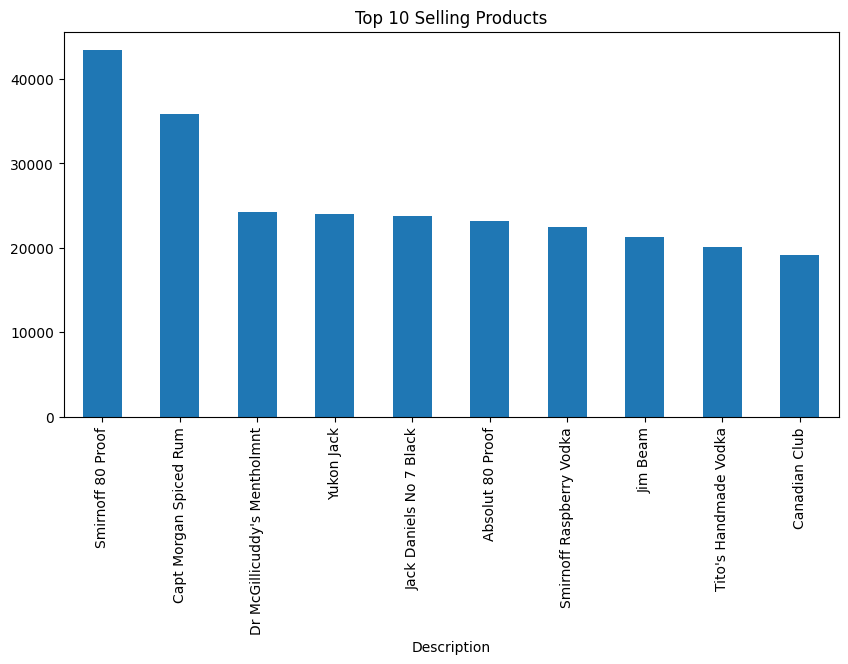

In [21]:
top_products.plot(kind='bar', figsize=(10,5), title="Top 10 Selling Products")
plt.show()

In [22]:
sales['Revenue'] = sales['SalesQuantity'] * sales['SalesPrice']

revenue_by_product = (
    sales.groupby('Description')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

revenue_by_product

Description
Capt Morgan Spiced Rum     610008.34
Jack Daniels No 7 Black    558064.03
Absolut 80 Proof           422095.29
Tito's Handmade Vodka      420186.25
Ketel One Vodka            417950.59
Jameson Irish Whiskey      410287.84
Grey Goose Vodka           394280.19
Baileys Irish Cream        294738.43
Kahlua                     290933.11
Jim Beam                   255837.61
Name: Revenue, dtype: float64

In [23]:
inventory = begin_inv.merge(
    end_inv,
    on=['InventoryId','Store','Brand','Description','Size','Price'],
    suffixes=('_begin', '_end')
)

inventory['AvgInventory'] = (
    inventory['onHand_begin'] + inventory['onHand_end']
) / 2

## Sales Analysis

Historical sales data is aggregated to understand demand behavior
across products and time periods.

In [24]:
sales_qty = sales.groupby('Brand')['SalesQuantity'].sum().reset_index()

inventory_turnover = inventory.merge(
    sales_qty, on='Brand', how='left'
)

inventory_turnover['InventoryTurnover'] = (
    inventory_turnover['SalesQuantity'] /
    inventory_turnover['AvgInventory']
)

## ABC Inventory Classification

ABC analysis classifies products based on their contribution
to total sales value, enabling prioritization of inventory control.

In [25]:
abc = (
    sales.groupby('Description')['Revenue']
    .sum()
    .reset_index()
    .sort_values(by='Revenue', ascending=False)
)

abc['CumulativeRevenue'] = abc['Revenue'].cumsum()
abc['CumulativePercent'] = abc['CumulativeRevenue'] / abc['Revenue'].sum()

In [26]:
def abc_class(x):
    if x <= 0.7:
        return 'A'
    elif x <= 0.9:
        return 'B'
    else:
        return 'C'

abc['ABC_Class'] = abc['CumulativePercent'].apply(abc_class)

In [27]:
abc['ABC_Class'].value_counts()

ABC_Class
C    4931
B    1285
A     674
Name: count, dtype: int64

### ABC Insights

Category A products contribute the majority of revenue and
require strict monitoring. Category C products can be managed
with relaxed controls.

In [ ]:
## Economic Order Quantity (EOQ) Analysis

EOQ is calculated to determine the optimal order size that
minimizes ordering and holding costs.

In [28]:
annual_demand = sales.groupby('Brand')['SalesQuantity'].sum()
price = price_list.set_index('Brand')['PurchasePrice']

df_eoq = pd.concat([annual_demand, price], axis=1).dropna()
df_eoq.columns = ['Demand', 'UnitCost']

ordering_cost = 50
holding_rate = 0.2

df_eoq['EOQ'] = np.sqrt(
    (2 * df_eoq['Demand'] * ordering_cost) /
    (holding_rate * df_eoq['UnitCost'])
)

df_eoq.head()

,Demand,UnitCost,EOQ
Brand,,,
58,288.0,9.28,124.568220
60,124.0,7.40,91.533482
61,24.0,10.60,33.646329
62,162.0,28.67,53.153108
63,131.0,30.46,46.371986


In [29]:
daily_demand = df_eoq['Demand'] / 365
lead_time_days = 7

df_eoq['ReorderPoint'] = daily_demand * lead_time_days

In [30]:
lead_time = (
    purchases['ReceivingDate'] - purchases['PODate']
).dt.days

In [31]:
lead_time.describe()

count    2.372474e+06
mean     7.620739e+00
std      2.208890e+00
min      3.000000e+00
25%      6.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.400000e+01
dtype: float64

## Sales Trend Analysis

Historical sales data was analyzed to identify overall demand patterns and
variations across time. This helps understand seasonality and demand stability,
which are critical for inventory planning.

In [32]:
daily_sales = (
    sales.groupby('SalesDate')['SalesQuantity']
    .sum()
    .asfreq('D')
    .fillna(0)
)

## Demand Forecasting

Historical sales data is used to estimate future demand.
Forecasting helps prevent stockouts and overstocking by enabling
proactive inventory planning.

In [35]:
model = ExponentialSmoothing(
    daily_sales,
    trend='add',
    seasonal='add',
    seasonal_periods=7
)

forecast_model = model.fit()
forecast = forecast_model.forecast(30)

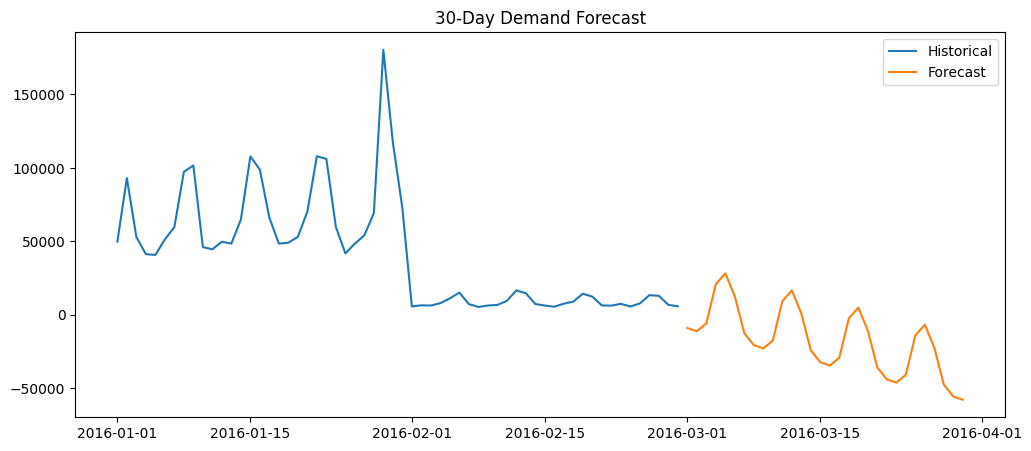

In [36]:
plt.figure(figsize=(12,5))
plt.plot(daily_sales[-60:], label='Historical')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title("30-Day Demand Forecast")
plt.show()

### Forecast Insights

The forecast indicates relatively stable demand with moderate
variation. High-demand products should maintain sufficient
safety stock to meet future requirements.
